In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [6]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train.csv")
X_test = pd.read_csv(f"{base_url}/X_test.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 13) (8639, 13)
(34554, 1) (8639, 1)


During the dataset adjustment and EDA phases, we made significant preparations to simplify the data. This included dropping irrelevant features, combining others for simplification (day + month), and addressing missing values. As a result, our feature engineering process will focus on refining and finalizing the dataset rather than making major changes. While addressing imbalanced data, we experimented with SMOTE-based techniques to enhance minority class representation this feature engineering part. However, this approach led to overfitting (boosting models are sensitive to this), so we decided to handle the class imbalance directly within the model using strategies like class weighting/tunning. As a result, our feature engineering will focus on refining the dataset while relying on the model to address the imbalance effectively.

# Feature Engineering

## Additional Features
1. `customer_value_score`:

First, let’s create a column named `customer_value_score` based on balance, previous campaign contacts, and penalties for active loans. This acts like a credit score, giving the model a clear perspective on customer value and helping it do a better job at predicting subscribers. It’s a simple way to give the model a smarter starting point!

In [12]:
# Calculation of customer value score 
total_loans = X_train.apply(lambda x: int(x['housing'] == 'yes') + int(x['loan'] == 'yes'), axis=1)
X_train['customer_value_score'] = X_train['balance'] * (1 + X_train['previous']) - (total_loans * 1000)

total_loans = X_test.apply(lambda x: int(x['housing'] == 'yes') + int(x['loan'] == 'yes'), axis=1)
X_test['customer_value_score'] = X_test['balance'] * (1 + X_test['previous']) - (total_loans * 1000)

**`balance * (1 + X_train['previous'])`**:

- This amplifies the effect of a client's balance by factoring in their past engagement (`previous contacts`). The idea is that clients with higher balances and a history of interactions are more likely to be valuable. This matches real life—customers with more money and more engagement are usually more valuable.

**`total_loans * 1000`**:  
-  Subtracting 1000 for each loan reflects the assumption that customers with active loans may have less disposable income, lowering their overall value. This penalty adjusts the score to account for financial commitments.

### Overall Purpose
The formula balances **wealth** (balance and past interactions) with **financial constraints** (active loans), creating a dynamic `customer_value_score`. This score provides a nuanced measure of customer value to help the model prioritize patterns and improve predictions.

### Lets check the distribution of `customer_value_score` column:

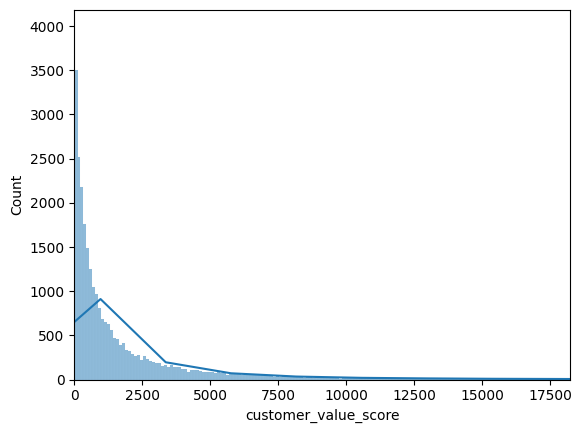

In [16]:
sns.histplot(X_train['customer_value_score'], kde=True)
plt.xlim(0, X_train['customer_value_score'].quantile(0.98))
plt.show()

To deal with skewness, lets apply log transformation and check whether it helped compress the skewness.

Looks better now!

2. `estimated_income`:

It also seems reasonable to create an `estimated_income` variable since it shows a customers financial situation.

The feature will be based on their job, education, balance and loans because:

- `balance`: A higher balance likely indicates higher financial stability or disposable income, so using it as a base is logical.
- `job`: Assigning weights based on job ranking reflects the assumption that certain jobs are typically associated with higher income levels (e.g., management, blue-collar work, etc).
- `education`: Higher education levels often correlate with higher earning potential, making this a valid inclusion as well.
- Loans (`housing` and `personal`): Penalizing for loans acknowledges that clients with loans may have less disposable income, which could affect their financial health.

In [21]:
# Job ranking
job_ranking = {
    'management': 5, 'admin.': 4, 'technician': 4, 'entrepreneur': 4, 
    'blue-collar': 3, 'services': 3, 'self-employed': 4, 'retired': 2, 
    'student': 1, 'unemployed': 1, 'housemaid': 2, 'unknown': 1
}

# Education ranking
education_ranking = {
    'tertiary': 3,  # University level
    'secondary': 2,  # High school level
    'primary': 1,  # Primary school level
    'unknown': 1  # Unknown education level
}

# proxy feature for loans (both housing and personal loan)
total_loans = X_train.apply(lambda x: int(x['housing'] == 'yes') + int(x['loan'] == 'yes'), axis=1)

# Calculating estimated income using balance, job, education, and loans
X_train['estimated_income'] = (
    X_train['balance'] * 1 +  # Balance weight
    X_train['job'].map(job_ranking) * 5000 +  # Job weight
    X_train['education'].map(education_ranking) * 1000  # Education weight
    - total_loans * 1000  # Loan penalty
)

In [23]:
# lets repeat the same for the test set
total_loans = X_test.apply(lambda x: int(x['housing'] == 'yes') + int(x['loan'] == 'yes'), axis=1)

# Calculating estimated income using balance, job, education, and loans
X_test['estimated_income'] = (
    X_test['balance'] * 1 +  # Balance weight
    X_test['job'].map(job_ranking) * 5000 +  # Job weight
    X_test['education'].map(education_ranking) * 1000 # Education weight
    - total_loans * 1000  # Loan penalty
)

The weights (`1000`, `1000`, and `5000`) reflect logical assumptions about income factors:

- **`Job Ranking`**: Jobs strongly influence income, so they get the highest weight.  
- **`Education`**: Education affects earning potential but less directly, so it has a smaller weight.  
- **`Loans`**: A penalty of 1000 per loan accounts for reduced disposable income.

These weights are intuitive and provide a simple, interpretable starting point. They balance practicality with reasonable assumptions and can be refined later if needed.  

### Lets check the distribution of `estimated_income` column:

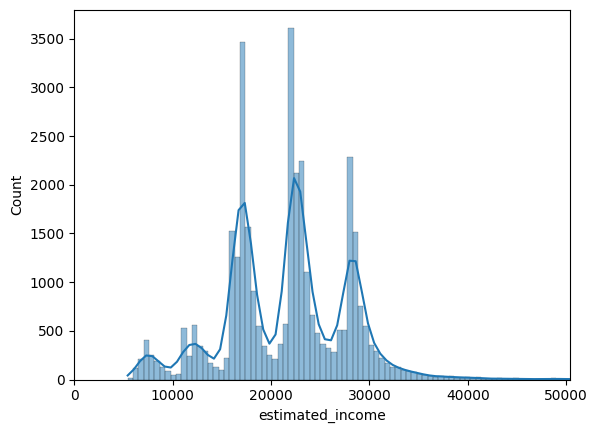

In [27]:
# Lets examine the distribution of 'estimated_income' column
sns.histplot(X_train['estimated_income'], kde=True)
plt.xlim(0, X_train['estimated_income'].quantile(0.998))
plt.show()

The chart shows multiple peaks, meaning there are distinct groups in the data, like different income levels. There’s a slight right skew (higher incomes are less common), but it’s not extreme. A log transform isn’t needed right now since the data looks manageable and the group patterns are clear.

### 3. Let’s create some more features:

In [31]:
# Balance per contact
# This feature looks at how much balance a customer has compared 
# to how often they’ve been contacted in previous campaigns.
X_train['balance_per_contact'] = X_train['balance'] / (1 + X_train['previous'])

# Age-to-balance ratio
# This feature compares balance to age, highlighting 
# financial behavior at different life stages.
X_train['age_balance_ratio'] = X_train['balance'] / (1 + X_train['age'])

# same for test
X_test['balance_per_contact'] = X_test['balance'] / (1 + X_test['previous'])
X_test['age_balance_ratio'] = X_test['balance'] / (1 + X_test['age'])

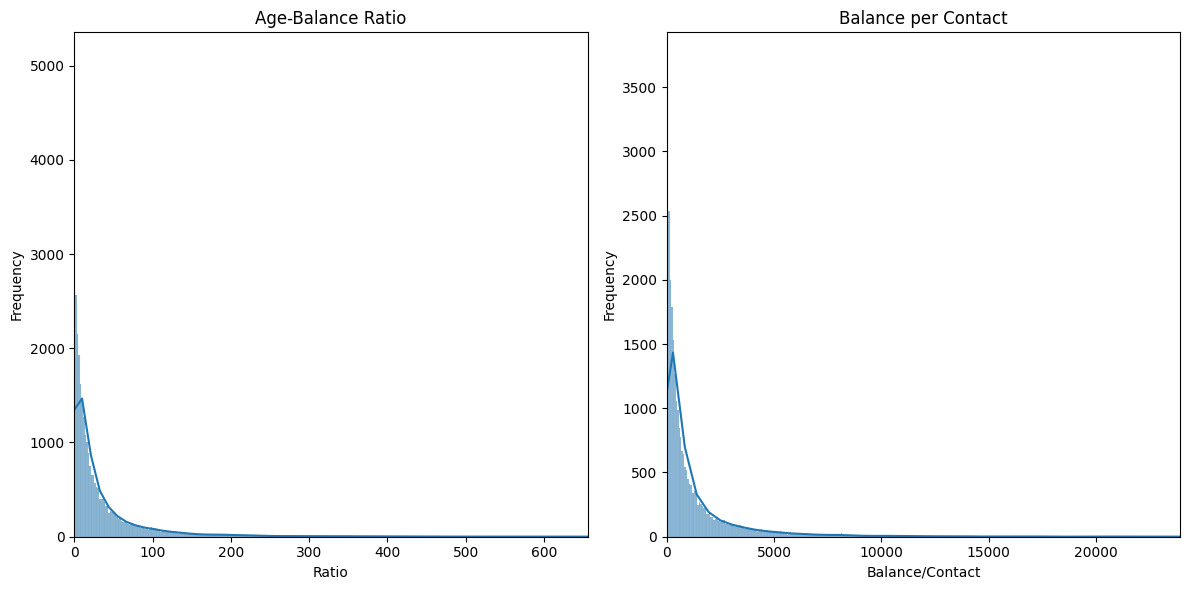

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# age-balance ratio
sns.histplot(X_train['age_balance_ratio'], kde=True, ax=axes[0]).set(
    xlim=(0, X_train['age_balance_ratio'].quantile(0.998)),
    title="Age-Balance Ratio", xlabel="Ratio", ylabel="Frequency"
)

# balance per contact
sns.histplot(X_train['balance_per_contact'], kde=True, ax=axes[1]).set(
    xlim=(0, X_train['balance_per_contact'].quantile(0.998)),
    title="Balance per Contact", xlabel="Balance/Contact", ylabel="Frequency"
)

plt.tight_layout()
plt.show()

## Log-tranformation

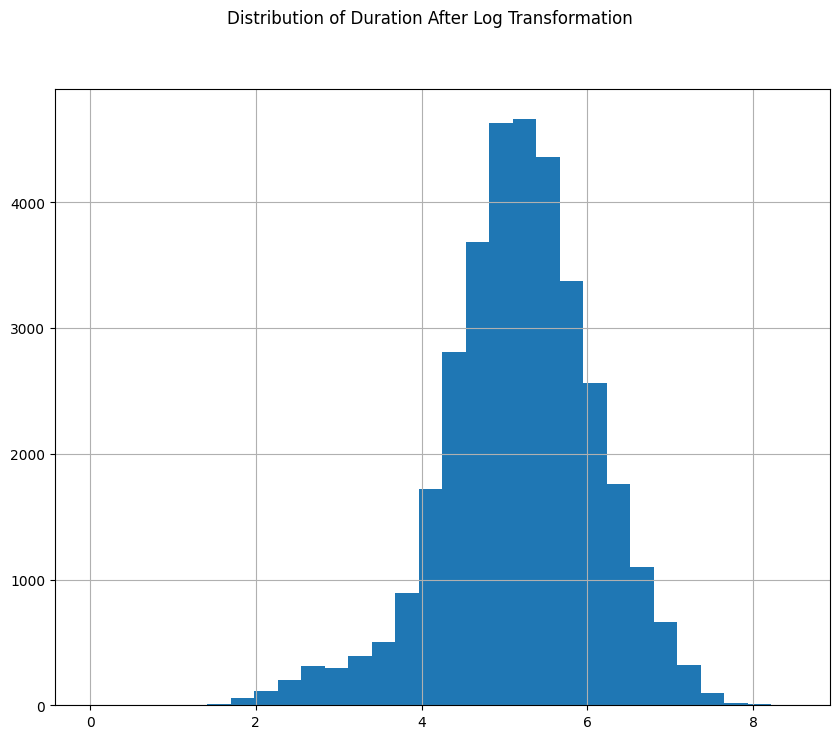

In [36]:
# log transformation
X_train['duration'] = np.log(X_train['duration']+1)
X_test['duration'] = np.log(X_test['duration']+1)

# plot histogram
X_train['duration'].hist(bins=30, figsize=(10, 8))
plt.suptitle("Distribution of Duration After Log Transformation")
plt.show()

## Binning to create additional features

We’re grouping continuous variables like `age` and `previous` into categories (or "bins") to better capture patterns that might not be linear. Here’s why:

- **For `age`**: We’re dividing ages into groups (e.g., Young, Middle-aged, Senior, Elderly) based on the same idea we explored in the EDA—different age groups may have different financial situations or behaviors, like disposable income. Younger clients might behave very differently from older ones, and these bins help the model pick up on those patterns.

- **For `previous`**: We’re creating bins (e.g., none, low, medium, high) to reflect client engagement in past campaigns. For example, someone with no previous contacts (`none`) might behave very differently from someone with high engagement (`high`). This distinction helps the model understand how past behavior impacts the likelihood of subscribing.

By binning, we make these variables more interpretable and easier for the model to use, while also capturing important group-specific trends!

In [39]:
# Binning 
X_train['age_bin'] = pd.cut(X_train['age'], bins=[18, 30, 50, 70,X_train['age'].max()], labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])
X_train['previous_bin'] = pd.cut(X_train['previous'], bins=[-1, 0, 2, 5, np.inf], labels=['none', 'low', 'medium', 'high'])

X_test['age_bin'] = pd.cut(X_test['age'], bins=[18, 30, 50, 70,X_test['age'].max()], labels=['Young', 'Middle-aged', 'Senior', 'Elderly'])
X_test['previous_bin'] = pd.cut(X_test['previous'], bins=[-1, 0, 2, 5, np.inf], labels=['none', 'low', 'medium', 'high'])

Lets add another one for days since last contact:

In [42]:
# Binning 'pdays' into categories:
# - 'no contact': No prior contact (-1).
# - 'recent': Contacted within the last month.
# - 'moderate': Contacted between 1 to 3 months.
# - 'long ago': Contacted between 3 to 6 months.
# - 'very long ago': Contacted over a year ago.

X_train['adjusted_pdays'] = X_train['pdays'].replace(-1, -999)
X_test['adjusted_pdays'] = X_test['pdays'].replace(-1, -999)

bins = [-1000, 0, 30, 90, 365, X_train['pdays'].max()]
labels = ['no contact', 'recent', 'moderate', 'long ago', 'very long ago']

X_train['last_contact_days_bin'] = pd.cut(X_train['adjusted_pdays'], bins=bins, labels=labels)
X_test['last_contact_days_bin'] = pd.cut(X_test['adjusted_pdays'], bins=bins, labels=labels)

X_train.drop(columns=['adjusted_pdays'], inplace=True)
X_test.drop(columns=['adjusted_pdays'], inplace=True)

X_train['last_contact_days_bin'].value_counts()

last_contact_days_bin
no contact       28181
long ago          5343
very long ago      491
moderate           401
recent             138
Name: count, dtype: int64

# Let's review the transformed data and export it.

In [44]:
X_train.head()

,age,job,marital,education,balance,housing,loan,contact,duration,pdays,previous,poutcome,contact_date,customer_value_score,estimated_income,balance_per_contact,age_balance_ratio,age_bin,previous_bin,last_contact_days_bin
0,55,blue-collar,married,secondary,16873,0,0,cellular,4.369448,-1,0,other,1-jun,16873,33873,16873.0,301.303571,Senior,none,no contact
1,34,technician,married,secondary,4,1,0,cellular,4.663439,263,1,failure,2-feb,8,22004,2.0,0.114286,Middle-aged,low,long ago
2,40,admin.,married,secondary,451,1,1,unknown,5.552960,-1,0,other,29-may,451,22451,451.0,11.000000,Middle-aged,none,no contact
3,29,services,single,secondary,-142,1,0,unknown,4.948760,-1,0,other,16-may,-142,16858,-142.0,-4.733333,Young,none,no contact
4,51,technician,divorced,secondary,131,1,0,cellular,5.267858,-1,0,other,18-nov,131,22131,131.0,2.519231,Senior,none,no contact


In [46]:
X_test.head()

,age,job,marital,education,balance,housing,loan,contact,duration,pdays,previous,poutcome,contact_date,customer_value_score,estimated_income,balance_per_contact,age_balance_ratio,age_bin,previous_bin,last_contact_days_bin
0,23,student,single,secondary,0,0,0,cellular,5.384495,99,7,success,7-aug,0,7000,0.0,0.000000,Young,high,long ago
1,28,admin.,single,secondary,1842,1,0,cellular,4.532599,-1,0,other,4-may,1842,23842,1842.0,63.517241,Young,none,no contact
2,32,admin.,single,secondary,1291,1,0,cellular,4.709530,-1,0,other,23-jul,1291,23291,1291.0,39.121212,Middle-aged,none,no contact
3,45,blue-collar,married,secondary,2603,1,1,cellular,5.463832,-1,0,other,7-aug,2603,19603,2603.0,56.586957,Middle-aged,none,no contact
4,53,management,married,tertiary,241,1,0,cellular,4.927254,-1,0,other,19-nov,241,28241,241.0,4.462963,Senior,none,no contact


In [48]:
print(X_train.shape, X_test.shape)

(34554, 20) (8639, 20)


In [50]:
X_train.to_csv("X_train_fe.csv", index=False)
X_test.to_csv("X_test_fe.csv", index=False)

print("Datasets successfully exported as CSV files.")

Datasets successfully exported as CSV files.
